In [1]:
import re
import requests
import json
import os
import pandas as pd
import numpy as np
import seaborn as sb
import warnings
import matplotlib.pyplot as plt

from operator import itemgetter
from nltk import tokenize, sent_tokenize, RegexpTokenizer, ngrams
from sklearn.decomposition import PCA
from scipy.sparse import hstack
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, normalize, Normalizer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
def liwc_analysis(text):
    X_API_SECRET_KEY = 'tg3OK1kcQdU8RXjx2ghyjNcB6vmg82nYALAS3ImVBYg'
    X_API_KEY = '584055def86167059a1c1d34'

    header = {}
    header['X-API-KEY'] = X_API_KEY
    header['X-API-SECRET-KEY'] = X_API_SECRET_KEY
    header['Content-type'] = 'application/json'

    url = 'https://api-v3.receptiviti.com/v3/api/content'
    
    
    payload = {"content_source": 0,
                              "language_content": text
          }
    try:    
        r = requests.post(url, headers=header, json=payload, timeout=45)
        json_to_dump = json.loads(r.text)
        return json_to_dump['liwc_scores']['categories']

    except Exception as e:
        print("error")
        pass


def create_liwc_df(text,temp):
    for i in range(1,len(text)):
        print(text[i])
        text = liwc_analysis(text[i])
        temp_obj = pd.DataFrame(data=text, index=[i])
        temp = pd.concat((temp, temp_obj), axis=0)
    return temp

In [3]:
def generate_wordcloud(text,title,max_words = 50):
    words = text['post_text'].str.cat()
    
    wordcloud = WordCloud(max_words=max_words,background_color='white', max_font_size=50).generate(words)

    # Display the generated image:
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def generate_CDF(data):

    temp_depression = data['num_words_post'].value_counts().sort_index()
    temp_depression /= np.sum(temp_depression.values)
    depression_indice_list = temp_depression.index
    temp_depression = temp_depression.reset_index().drop('index',axis=1)
    CDF_depression = np.zeros(len(temp_depression))
    CDF_depression[0] = temp_depression.iloc[0,0]


    for i in range(1, len(temp_depression)):
        CDF_depression[i] = CDF_depression[i-1] + temp_depression.iloc[i,0]
    return CDF_depression, depression_indice_list

    
    
def vector_transformers(text_column):

    count_vect = CountVectorizer()
    post_text = count_vect.fit_transform(text_column)

    tfidf_transformer = TfidfTransformer()
    post_text_tfidf = tfidf_transformer.fit_transform(post_text)

    return post_text_tfidf


# Clean dataset
def clean_data(dataset):
#     dataset = dataset[dataset['subreddit'] != 'depression']
#     dataset = dataset[dataset['subreddit'] != 'AskReddit']
    dataset['post_text'] = dataset['post_text'].fillna('')
    dataset = dataset[dataset['post_text'] != '[removed]']
    dataset['post_text'] = dataset['post_text'].apply(lambda x: x.replace('\r', ''))
    dataset['post_text'] = dataset['post_text'].apply(lambda x: x.replace('\n', ''))
    dataset['post_text'] = dataset['post_text'].apply(lambda x: x.replace("\'", ""))
    dataset = dataset.dropna()
    dataset = dataset.reset_index()

    return dataset

def post_to_wordlist(post, remove_stopwords=True, split=False):
    
    post = re.sub("[^a-zA-Z]"," ", post)
    words = post.lower().split()
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if split:
        return words
    else:
        return (' '.join(words))

In [4]:
# Load the data and clean it.
# if you have internet connection use the markdown below instead of this code block
# use this one only if you have the data file saved on your machine
df = pd.read_csv(r'/Users/giladgecht/Downloads/temp.csv')

df = shuffle(df)
encoder = LabelEncoder()
df['_subreddit'] = encoder.fit_transform(df['_subreddit'])
df['_post_text'] = df['_post_text'].fillna('')
df = df[df['_post_text'] != '[removed]']
df = df[df['_title_length'] >= 20]
df = df.dropna()

df = pd.read_csv('temp.csv')
encoder = LabelEncoder()
df['_subreddit'] = encoder.fit_transform(df['_subreddit'])
df['_post_text'] = df['_post_text'].fillna('')
df = df[df['_post_text'] != '[removed]']
df = df[df['_title_length'] >= 20]
df = df.dropna()

In [5]:
target = '_subreddit'
cols = '_title'

X = df[cols]
y = df[target]

count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word')
X = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 1,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

In [8]:
print("Accuracy Score:",score)
print(confusion_matrix(y_pred=y_pred,y_true=y_test))
print("AUC Score:", np.mean(cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc')))

Accuracy Score: 0.8620811287477954
[[1575  167]
 [ 224  869]]
AUC Score: 0.938044736323558


In [9]:
feature_names = np.array(count_vect.get_feature_names())
sorted_coef_index = svc.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['reddit' 'redditors' 'movie' 'did' 'hype' 'thing' 'questions'
 'hermaphrodite' 'stranger' 'askreddit']

Largest Coefs: 
['depression' 'suicide' 'therapy' 'depressed' 'therapist' 'bed' 'suicidal'
 'anymore' 'im' 'feel']



In [10]:
# Load main dataset and clean it by removing deleted posts and filling presumed posts with pictures with ''
# Apply the trained LinearSVC classifier on the dataset
whole_data = pd.read_csv(r'/Users/giladgecht/PycharmProjects/DepressionResearch/Create_Data/SubmissionsDF.csv',index_col=0)
whole_data = clean_data(whole_data)
whole_data['predicted'] = svc.predict(count_vect.transform(whole_data['title']))
whole_data.shape

(276500, 18)

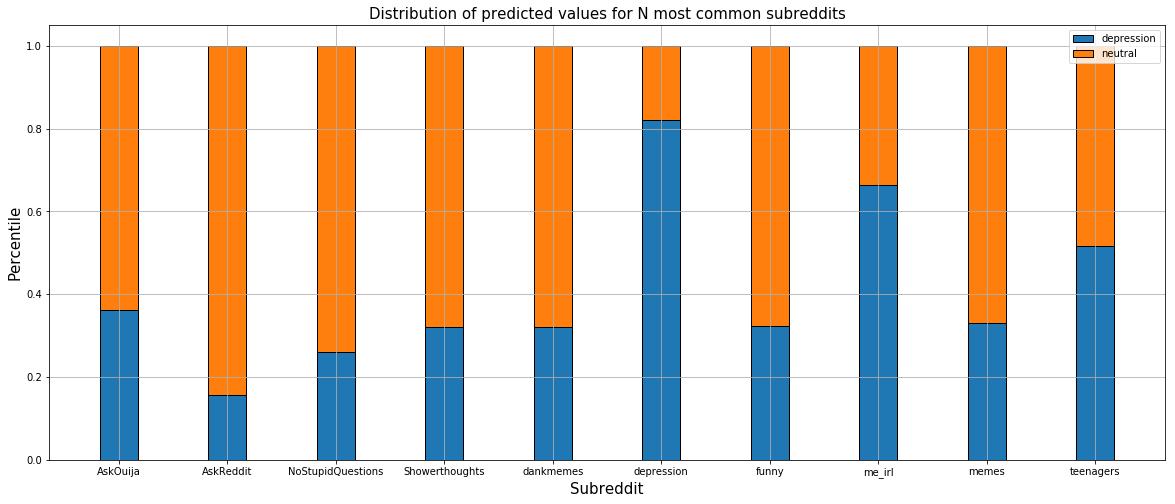

In [11]:
# for the top n common subreddits (probably depression related)
# plot the distribution of predicted neutral posts vs depression posts 
# i.e. subreddit = 'depression', num_posts = 3000, predicted_1 = 2500 (depression), predicted_0 


N = 10
most_common_subreddits = list(whole_data['subreddit'].value_counts().nlargest(N).keys())
most_common_subreddits = whole_data[whole_data['subreddit'].isin(most_common_subreddits)]

temp = most_common_subreddits['subreddit'].value_counts()
sum_subreddit_dict = temp.to_dict()

temp = most_common_subreddits.groupby(['subreddit','predicted'], as_index=False).agg({"submission_id":"count"})
temp['appearance'] = temp['subreddit'].apply(lambda x: sum_subreddit_dict[x])
temp['submission_id'] /= temp['appearance']

pred_depression = temp.iloc[1::2,:]
pred_neutral = temp.iloc[::2,:]

ind = np.arange(N)
width = .35
plt.figure(figsize=(20,8))
p1 = plt.bar(ind, pred_depression['submission_id'], width, edgecolor='k', label='depression')
p2 = plt.bar(ind, pred_neutral['submission_id'], width, edgecolor='k', label='neutral',bottom=pred_depression['submission_id'])


plt.title("Distribution of predicted values for N most common subreddits", size=15)
plt.ylabel('Percentile',size=15)
plt.xlabel('Subreddit', size=15)
plt.xticks(ind, list(pred_depression['subreddit'].values))
plt.legend()
plt.grid()
plt.show()


In [12]:
# Distribution of predicted values
whole_data['predicted'].value_counts()

0    168375
1    108125
Name: predicted, dtype: int64

In [13]:
# Filter out the data by noise
# Subreddits with less than 50 appearences are dropped out 
counts = whole_data['subreddit'].value_counts()
popular_subreddits = counts[counts.values >= 50].keys()
whole_data = whole_data[(whole_data['subreddit'].isin(popular_subreddits))]

In [14]:
# Number of UNIQUE subreddits left after being filtered
subreddits = set(whole_data['subreddit'])
len(subreddits)

830

In [15]:
# Apply a second filter,
# by checking the tendency of a certain subreddit to be either depression or neutral
# if its over 70% towards a certain side, append to the appropriate list

neutral_subreddits = []
depression_subreddits = []
for i in subreddits:
    values = whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values
    sum_values = np.sum(whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values)
    values_perc = values/sum_values
    value1 = whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values[0]
    if whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().keys()[0] == 0:
        if values_perc[0] >= 0.7:
            neutral_subreddits.append(i)
    else:
        if values_perc[0] >= 0.7:
            depression_subreddits.append(i)

In [16]:
# Distribution of depression subreddits 
whole_data[whole_data['subreddit'].isin(depression_subreddits)]['subreddit'].value_counts()

depression             21304
SuicideWatch            1980
Anxiety                 1457
offmychest              1079
mentalhealth             657
selfharm                 626
relationship_advice      603
relationships            441
lonely                   390
BreakUps                 285
DoesAnybodyElse          274
Needafriend              233
selfimprovement          182
Vent                     166
depression_help          146
AmItheAsshole            118
ForeverAloneDating        93
CPTSD                     79
antidepressants           72
LongDistance              72
depressed                 63
sleep                     56
DAE                       55
TalkTherapy               54
Name: subreddit, dtype: int64

In [17]:
print("The Filtered Neutral Subreddits Are:\n\n",neutral_subreddits)
print(20*"-")
print("The Filtered Depression Subreddits are:\n\n", depression_subreddits)

The Filtered Neutral Subreddits Are:

 ['DMT', 'electricians', 'OnlineDating', 'Frugal', 'gratefuldead', 'explainlikeimfive', 'MaddenUltimateTeam', 'Stellaris', 'borrow', 'ifyoulikeblank', 'fuzzing', 'DMAcademy', 'Entrepreneur', 'shittyfoodporn', 'Minecraft', 'PoliticalHumor', 'MovieSuggestions', 'Bandnames', 'NoStupidQuestions', 'runescape', 'YellowOnlineUnion', 'thesims', 'creepy', 'Guitar', 'ShitPostCrusaders', 'forza', 'tattoos', 'totalwar', 'therewasanattempt', 'IASIP', 'hmmm', 'WritingPrompts', 'Twitch', 'EarthPorn', 'languagelearning', 'AskReddit', 'brasil', 'Gamingcirclejerk', 'FanTheories', 'bindingofisaac', 'anime_irl', 'news', 'reddeadredemption', 'DeepIntoYouTube', 'HomeImprovement', 'Brawlhalla', 'mbti', 'freefolk', 'Music', 'fakehistoryporn', 'ladyladyboners', 'heck', 'Fishing', 'canada', 'ATBGE', 'weekendgunnit', 'dankchristianmemes', 'gifs', 'Toontown', 'brockhampton', 'Xcom', 'Cooking', 'whowouldwin', 'ukpolitics', 'gamemusic', 'Conservative', 'engrish', 'Bitcoin', 'Ro

In [18]:
# Filtered by hand depression-related subreddits
depression_subreddit_filtered_list = ['depression_help', 'lonely', 'SuicideWatch', 'depression',
                                      'selfharm', 'mentalhealth', 'offmychest', 'Anxiety',]

In [19]:
# Split the dataframe to neutral and depressed by the filtered subreddits
depression_df = whole_data[whole_data['subreddit'].isin(depression_subreddit_filtered_list)]
neutral_df = whole_data[whole_data['subreddit'].isin(neutral_subreddits)]

In [20]:
# Get the list of all unique users for each type of dataset
depression_names = list(set(depression_df['user_name']))
neutral_names = list(set(neutral_df['user_name']))

In [21]:
# Merge them back to a single dataframe
full_df = pd.concat([depression_df,neutral_df],axis=0)
full_df.shape

(82320, 18)

In [22]:
# Filter out people who havn't posted in both types of subreddits (Depression/Neutral) in the current dataset
both = []
for i in depression_names:
    if i in neutral_names:
        both.append(i)

In [23]:
full_df = full_df[full_df['user_name'].isin(both)]
full_df = full_df.sort_values(by=['user_name','date_created'],ascending=False)
full_df['num_distinct_words'] = full_df['post_text'].apply(lambda x: len(set(x.split())))

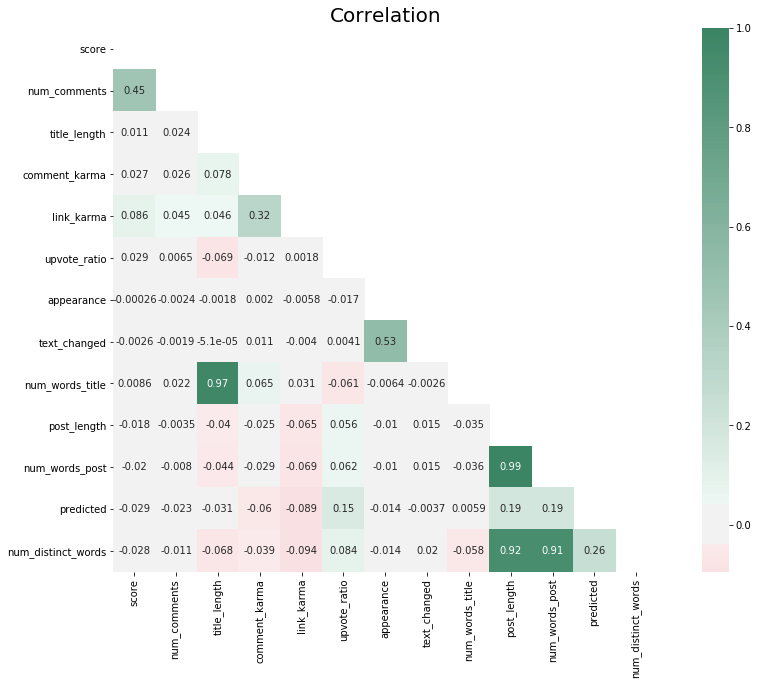

In [24]:
df_corr = full_df._get_numeric_data()

mask = np.zeros_like(df_corr.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sb.diverging_palette(10,150,as_cmap=True)

plt.figure(figsize=(16,10))
sb.heatmap(df_corr.corr(),cmap=cmap,annot=True,mask = mask,square = True,center = 0)
plt.title('Correlation',size=20)
plt.show()

In [25]:
# Create a colum comprised of tri-grams of the post's text
full_df['tokenized'] = full_df['post_text'].apply(lambda x: x.split())

blabla = []
for row in full_df['tokenized']: # Iterate over each row
    generated_3grams = []

    for word in row: # iterate over each word in the row
        generated_3grams.append(list(ngrams(word, 3, pad_left=True, pad_right=False, left_pad_symbol='_')))

    temp_bla = []
    for i in generated_3grams:# iterate over each list in the 3gram
        for j in i: # iterate over each tuple in the current list
            temp_bla.append(j)
    blabla.append(temp_bla)
    
full_df['trigrams'] = 0 
full_df = full_df.reset_index().drop('index',axis=1)

for i in range(len(full_df['trigrams'])):
    full_df['trigrams'][i] = blabla[i]
    
for i in range(len(full_df['trigrams'])):
    ng_list_3grams = full_df['trigrams'][i]
    for idx,val in enumerate(full_df['trigrams'][i]):
        ng_list_3grams[idx] = ''.join(val)
        
        
    full_df['trigrams'][i] = ng_list_3grams

full_df['trigrams'] = full_df['trigrams'].apply(lambda x: ' '.join(x))
full_df = full_df.drop('tokenized',axis=1)

In [26]:
# Load the existing liwc dataframe, since there might have been a few errors in the creation,
# we'll drop the Nulls and eventually create a set of the existing submission ids
liwc = pd.read_csv('temp2.csv',index_col = 0)
liwc = liwc.dropna()
liwc_submission_ids = list(set(liwc['submission_id']))
liwc.shape

(22447, 86)

In [27]:
# TODO: Check if this block is needed, block above might provide already the needed columns
# Create a sample liwc object to get all the relevant features
X_API_SECRET_KEY = 'tg3OK1kcQdU8RXjx2ghyjNcB6vmg82nYALAS3ImVBYg'
X_API_KEY = '584055def86167059a1c1d34'

header = {}
header['X-API-KEY'] = X_API_KEY
header['X-API-SECRET-KEY'] = X_API_SECRET_KEY
header['Content-type'] = 'application/json'

url = 'https://api-v3.receptiviti.com/v3/api/content'

body = """ 
i feel like i’ve waisted it trying to get his help. i can’t connect with him, which makes me feel less like i can open up to him. i don’t particularly enjoy my time there, and i often don’t feel like i’ve gained anything from our sessions.i haven’t gone to see him in a few months. since then i’ve had about 10 mental breakdowns where i’ve felt as though i was hopeless, 5 panic attacks while driving, and like a heck ton of panic attacks at home. whenever i drive i just start crying uncontrollably. whenever i’m at home i hate myself and all i can think about is how i’d rather be dead than living with myself. i keep having panic attacks at work, my work performance is pretty crap because i can’t focus, and i fall asleep while sitting up because i can’t find peace at night.my grades have drastically dropped, and my dad tells me that it’s all my fault, and that i only want a new counselor because my friend has a counselor so i think it’s cool. i hate myself so much right now, and nobody i know has been able to comfort me.i feel so deprived of support, and i just want this feeling to end. if someone told me that they were here for me and gave me a hug i think i would implode on myself, because nobody has held me while i cried or told me that they would be here for me while i struggle with anxiety and depression
"""
#payload = {"content_source": 0,
#                               "language_content": unicode(TextFileContents, errors='ignore')

payload = {"content_source": 0,
                              "language_content": body
          }


#print payload

r = requests.post(url, headers=header, json=payload, timeout=45)
#print r.text
json_to_dump = json.loads(r.text)
# except e as err:
#         print("error"+err.msg)
liwc_cols = list(json_to_dump['liwc_scores']['categories'].keys())

In [28]:
# Keep only the posts where the submission id is in the analyzed liwc dataframe
# eventually we'll merge the 2 dataframes by their submission ids
full_df = full_df[full_df['submission_id'].isin(liwc_submission_ids)]
full_df = pd.merge(full_df, liwc,how='left', on='submission_id',)

In [29]:
# Find by using regular expressions all the sentences
# which are built in the following way: "i ...... depress/ed/ion/ants and so on"

count = 0
sentences = []
post = []
subreddits = []
for row in full_df.iterrows():
    
    sentence = row[1]['post_text']
    bla = re.findall(r'\bi\s.*\bdepress[\w]*\b', sentence)
    if len(bla) > 0:
        print(bla)
#         print("User:",row[1]['user_name'])
        print("Subreddit:",row[1]['subreddit'])
        print(10*'-')
        post.append(row[1]['submission_id'])
        subreddits.append(row[1]['subreddit'])
        sentences.append(sentence)
        count += 1
print(count)

['i took a gap year, and because i really had no idea what to do after that, i decided to go to college. big mistake!things went well at first. i was going to my classes, doing my work, going to the gym everyday. it was everything college should be. then one faithful day, i decided to start doing adderall. hmmm, ive never done any stimulants, this should be an interesting experience!well it sure was because i got addicted almost right away. 1 pill of 30mg xr adderall turned into 4 a day. straight up snorting it most of the time. then id go into crazy mental rampages, buying stupid shit, trying to fuck girls on tinder, etc.and this is where it gets even better. when i finally did fuck a girl i met on tinder, i went absolutely insane! after she cut things off with me, i stopped getting out of bed. i stopped going to class and going to the gym, i just laid in bed and wanted to die all day. id just dream of getting fucked up or killing myself.that went on for a few weeks and then i decided

Subreddit: depression
----------
['i had a depressive']
Subreddit: depression
----------
['i was "forced to experience because of living with my parents and so on (everybody knows the deal with the numerous restrictions on minors which made us rely on our parents good will and they dont always want us to experience things as they should be).but my problem is i wasnt able to act on things for so long, ive always had to satisfy with what i got and now when i can get more, i feel like i want do the out of the ordinary things because all these years of not being able to shape my life, i got used to the way things were.im not a person who would make huge steps in life, extraordinary, very risky decisions (even if well-thought over) and i need to find this courage in order to have a successful and interesting life - which is what i want.i also suffer from depression which disables me to do things and to believe in myself. depression']
Subreddit: depression
----------
['i appreciate the senti

----------
['i am not subscribed. i just wanted to vent, so i hope that i have at least come to the right place. i have recently acquired some rope from my local hardware depot, and on my way home from work tonight have found the ideal place to carry out my plan, not too far from my home and easily accessible with the aide of my chair.&#x200b;for far too long i have been dealing with multiple mental health issues - chronic depression, anxiety, complex ptsd, asd, inferiority complex, and maybe more which i may not be aware of. im nearly 30 years old, raised by narcissistic parents; my father was physically and mentally abusive, while my mother was emotionally abusive and would guilt-trip me whenever i showed any signs of feeling depressed']
Subreddit: SuicideWatch
----------
['i have one question for you guys: what is your motivation for joining this sub? are you here because youve given up all hope on finding happiness but find comfort in being around people in the same state of mind a

['i have always wanted to write and start a journal, but when i was "normal," i was a bit biased towards it, and i said to myself who the hell has time to write in a diary.when depression hit, i realized i had time, and i needed a method to release my emotions and feelings. i turned to writing in a journal. i put my heart into journalling everyday for about six months releasing my emotions and negative thoughts into it. it helped my depression tremendously. as i started to recover, i built momentum from writing so much that i told myself that i should start a blog to help others and myself who are/were depressed. by starting a blog, i had something to do during my depression which now turned into a passion. i became more confident as what i write is honest and i am not putting a fake self *cough cough* like all the people on instagram and facebook. it helped me in discovering who i was as a person and what i wanted in my life. it made me feel more real and allowed me to show vulnerabil

Subreddit: offmychest
----------
['i dont...theres a lot of reasons why i am like this and why i treat, specially my mom, in such a hateful way.... i dont hate her, at least i dont tell her i do... she did stuff that you shouldnt be doing to a 14 yr old who is confused and so depressed']
Subreddit: offmychest
----------
['i was 6 at the time. since i was really young when that happend, i didnt remember much of it, bercause of it, my mom, being concerned about the trauma, decited to "hide" some stuff about my dad, of coude i dont blame her, if i was on her shoes i wouldve done the same...so on to the story.my dad, from my memories wasnt a great dad, he was acoholic and abusive towards my mom, sadly, she couldnt just leave my dad because at the time we were really depended on him. the only memory ive remember was one that my mom locked me and my borther in out room so that he wouldnt beat us...but the stuff gets worst. my mom didnt told me this until a few days ago, my dad... was a drug 

['i took a one month vacation and went back to see my parents, girlfriend, friends etc. i was doing really well in life. i barely felt depression, i was exercising regularly, meditating, eating well. my therapist told me that hes honestly in awe with the amount of progress ive made in the month i was away. my girlfriend stopped talking to me the moment i flew back from her. for a almost a month she kept saying that shes depressed. so i gave her space. when she tried to talk to me in the night, i said you can rather sleep because youre not feeling well. now i was worried what is up with her. she would see my message and not reply back and i distinctly remember that i couldnt sleep two nights because of all this. i was finally kicking depressions ass. and ive been fucking depressed forever. self-harm, hygine, i check every single box when it comes to depression. but i was kicking it. for the first time in my life. i wanted to go back to school, i wanted to do so much more. but now my gf,

----------
['i have been studying abroad for the past two years, and most of the time... i hated it. i means, even though the life standard, the social security is way ahead from my home country. but gosh, the loneliness is killing me. everyone, my parents, my old friends, my teachers, they keep saying, oh you should try meeting someone new, try to be socialize. every time i try, i try to engage the conversation as much as i can, in the end, theres only awkward silence in return. i had a fight with my uncle family last year, they are the one who "encourage" my mom to get me here. when i was a kid, they were my role model. but as i grew up, i felt like they was just some piece of scumbags who always bragging about how difficult they had been through and hows that make them better than everyone. it ended i was kicked out and had to find a new place to rent. my mom adored them, and ever since she had not stopped scolding me about it. my friends... hmmm... do i even have friend? my brother

Subreddit: depression
----------
['i compare myself to my friends who are doing so well and i feel like they think i’m an idiot. how am i going to get an internship next summer? will i even graduate on time? or get a job? i bet ill be a crappy, incompetent engineer. i wonder if ill even enjoy what i do, or if ill just end up stuck with a 9-5 job i hate for the rest of my miserable life.my relationship feels like its dying again. we already broke up once, then got back together, and now it feels like we’re headed in the same direction. i dont know what to do. it feels like shes making me more depressed']
Subreddit: depression
----------
['i get so mad sometimes hearing about people who are so depressed they just sleep and sit around feeling like crap all the time. im angry because every morning i wake up and i lay in bed and cry because i just want to stay there and hide from the world and i dont want to do this anymore and i hate life and im so done but i have so many bills and staying

----------
['i dont often post personal stuff on this site but today ive been feeling pretty down and just felt like venting for a little bit. i dont know if id consider myself to have bad depression, i definitely fall into the category of "anxiety" but depression has always come and gone. today is the first day that i called sick into work because of depression, even last night i just felt numb and sad and wanted to lie in my bed all day, i just had no desire to get up, ive lost a lot of interest in things i used to enjoy doing/watching, but im never in the mood to do anything anymore. i feel like i get like this when im hanging with coworkers, either inside or outside of work, for example, sunday night i had a bbq with a coworker of mine, and there was about 4/5 people there (all of which i like) but i find it tough to talk to them because i feel like i have zero personality, and all i want is to be able to connect with them on more of a "friendship" level than just a "co-worker" lev

['i hope these kinds of posts are allowed. i took an adder all in the morning, and had such a productive day and because of it my spirits were lifted. i dont know if i should be advocating for it, but it sure helped me immensely today. with the help of adderall* cleaned, dusted, vacuumed my room (this is such a mood lifter knowing how filthy my room was before)* washed my car, and vacuumed all the dust and crud from everywhere (i suppose the parentheses comment applies to this as well) * bought food and meal prepped, knowing im eating conscious and saving tons of money in the process* cut my toenails -- also sounds dumb but adds on to my productivity mood boostwithout adderall i can probably see my day going like this: * lied in bed* fapped to porn* napped* rinse and repeat i guess adderall -> productivity -> keeps the depression']
Subreddit: depression
----------
['i figure i’d try the pill because i can stop taking it if i get worse again. i’m just terrified of it making me suicidal 

Subreddit: depression
----------
['i have depression']
Subreddit: SuicideWatch
----------
['i do many things for others in my life that i fucking hate but i smile and put on a show nonstop i socialize and do so many things but inside im hoping to die constantly i teach kids at a job that pays minimum wage when i could have a much easier job that pays more and has more hours and less exhausting but i stay for the kids and helping the owner, i go to events and spend my money doing things i dont want to do for others and i cant get any homework done no matter how hard i try i end up sitting there staring at the screen literally doing nothing, ive had 2 days in a row before where i made it a goal to do a paper and i didnt get a single sentance done, ate next to nothing and just laid on the floor for hours upon hours, i am unable to move, one thing that i am interested in is exploring different states of consciousness and asking questions with phychedelics but thats illegal so i cannot go o

['i engage in small talk all day, with very little, but pleasant conversation with coworkers. once a month or so, they go out to a social function. i went with them, to get to know them a bit more. it faired well, and i learned i have indeed mastered small talk.however, it still bothers me that i cant develop closer friendships these days. most of my old friends are busy, and my attempts to befriend acquaintances typically yield the same results. so, i use small talk as a coping mechanism. the highlight of my day is making a shop clerk giggle or smile.i am not naive- i know i am nothing to them. i am barely something to my current friends. in response to that, i have given up on future pursuits of relationships. there is a deep fear in me i will let people down. i know the selfish, thoughtless, things i can do. i feel it is best to live a lie- to go in public and my job with a forced smile and charm. i feel like a scarecrow- resemblance of a human, with a forced smile, but whose goal i

In [30]:
count = 0
for row in full_df.iterrows():

    sentence = row[1]['post_text']
    bla = re.findall("my[\w]*\s.*depress[\w]*",sentence)
    if len(bla) > 0:
        print(bla)
        print("User:",row[1]['user_name'])
        print("Subreddit:",row[1]['subreddit'])
        print(10*'-')
        count += 1
print(count)

['my name is zavier and im a man that has really fucked up his life. so i took a gap year, and because i really had no idea what to do after that, i decided to go to college. big mistake!things went well at first. i was going to my classes, doing my work, going to the gym everyday. it was everything college should be. then one faithful day, i decided to start doing adderall. hmmm, ive never done any stimulants, this should be an interesting experience!well it sure was because i got addicted almost right away. 1 pill of 30mg xr adderall turned into 4 a day. straight up snorting it most of the time. then id go into crazy mental rampages, buying stupid shit, trying to fuck girls on tinder, etc.and this is where it gets even better. when i finally did fuck a girl i met on tinder, i went absolutely insane! after she cut things off with me, i stopped getting out of bed. i stopped going to class and going to the gym, i just laid in bed and wanted to die all day. id just dream of getting fucke

Subreddit: depression
----------
['my last little bit of optimism just went down the drain. i cant bring myself to ask for better hours without my mind pulling up the litany of ways that ive fucked up and dont deserve to work the shifts that actually make money. the other place where i thought i might get treated better specifically requires a bartending license (my unwillingness to get one being one of the major reasons im pretty sure im no longer getting good shifts at my current job). my student loans never responded to my request for forbearance to try and start repaying again, and theres no way i can pay over $1,400 for the couple months that i skipped repayment. my parents are mad at me because my delinquent loans are getting in the way of them getting loans to fix up the house.tonight, i really feel like im never going to get my life on track, like maybe my folks should just get to collect my life insurance pay out and use that to pay off these mother-fuckers. but i dont see any

Subreddit: SuicideWatch
----------
['my ex because i truly do love her with everything in me. she broke up with me a few months ago and things have been really frosty for the past month or so. every time i talk about suicide with her she takes it as “gaslighting” her and trying to hold it over her as a reason why she should be with me. it’s not my intent at all, i was depressed before her and have been since. as i said, i posted this on r/relationshipadvice earlier and i believe there was some misunderstanding probably because it was 5am and i didn’t include every detail. sub is also known for not being very compassionate. i never messaged her anything like “i’m going to kill myself if you don’t be with me or “i’m going to kill myself you need to help me” or any potentially gaslighting phrase. in fact, unless she would bring up depression']
User: theguyfromuncle420
Subreddit: SuicideWatch
----------
['my ex because i truly do love her with everything in me. she broke up with me a few m

Subreddit: depression
----------
['my life. they all are somewhat manageable for the most part with the help of....kratom - i discovered this awesome plant about a year ago and it is almost a cure-all for depression/anxiety issues for me. i do have to be mindful of my intake because it can be habit forming if used without care.weed - sure helps me get through the work day knowing that i have a nice treat waiting for me after work is complete. im just a happier, more chillaxed individual because of this great plant.coffee - boy do i love the anti-depressant effects of coffee. turns my morning frown upside down most days. again, dosage is key here because too much caffeine and im super anxious and shaky!cbd - a weed derived substance that does not have the "high" of full on weed, but does provide a nice calming feeling for me that helps me get through tough parts of my day. i use a vape pen for this and the effects seem to be more immediate as opposed to capsules or tincture drops.xanax 

----------
['my depression and anxiety stems from growing up being constantly abused by my estranged father - a guy i wish would die every single day. just the thought of him makes me cringe.i remember when i was 9 or 10, life was so great. i was running around, happy and excited all the time. in my early teens, my dads ambitions for his business failed, over and over, and he took it out on me. we grew up poor, at the edge of a very rich town but in a tiny shack of a house...so i got to go to school with all the happy rich kids.my dad beat me. worse that the beatings were the threat of them. i never knew what would set him off. i would sigh too loud at dinner, and suddenly, he would stand up, scream at my, slap me and throw my soup bowl across the table or onto my lap and burn me. i walked on eggshells all the time. the stayed with friends all the time. when i had to come home, i constantly waited for that little light in the crack under the door to my parents room turn off...thats the

['my depression']
User: qaezec
Subreddit: depression
----------
['my head. i cant explain it but i just feel depressed and i want to avoid people, and theres a negative vibe about me inside. i just dont want to do anything or see anyone. its really bad, i need help its getting worse these days, in the past few years it was manageable but these days its getting worse and worse.i have a therapist i could see, ive tried pills and i dont want to go back, i havent had anytime to exercise the last 4 or 6 months now, probably two jogs on the treadmill.i could talk to a therapist but she just gets me to do things that i dont really want to do, i dont have friends and she thinks they would help. i dont know i just have low self esteem, i cant explain depression']
User: purplesfresh
Subreddit: depression
----------
['myself in any wayi’m 95% sure i have social anxiety and that’s stopped me from asking a girl i like out nothing traumatic has ever happened to me am i depressed']
User: puncakeking8

['my life, and it worsened my psychology to the point of me being hospitalized.i got diagnosed and found quite insane, suffering from personality disorders and a wrecked sense of my own worth. this was 10 years ago. since then i was in recovery, with ultimately me now working, very happy but poor as fuck, in a workspace for persons with psychological disabilities.earlier this year i learned that opposed to what i always thought, i actually did have acces to quite strong psychedelics. you see. i dont have much social life. i dont know any dealers. neither do i want to. i just learned i do not need dealers. i just need knowledge.these substances always interested me. i suffer from a mental disability, i have no visual imagination. the idea of tripping and seing things always fascinated me.now, to keep it short, i studied, i tried. i healed, i left behind and transcended many of my disabilities.&#x200b;the long and short of it of it all was, that i understood that the core of my depressio

['my sex drive and deal with these antidepressant']
User: majorphyl
Subreddit: depression
----------
['my grandmother (moms side), then 2 weeks later visited my aunts and uncles (on dads side) is when my depression sky rocketed.my grandmother definitely since my mom was a teenager in that house (she died almost 2 yrs ago).  also some anxiety since she became bitter and hates my dad for marrying too soon (i dont blame her, i dont like him right now and cant speak to his wife)my aunt and uncle were great, except my uncle is showing the first signs of parkinsons so thats made me nervous (ive lost 3 grandparents and mom over the course of 5 years).thats when i had a really low episode nothing about taking my life, but just miserable (like my marriage would end after cheating on my then fiance 24 years ago - we have talked about it then was forgiven and been happily married for 13 years).  my brain just didnt remember that.my husband suggested checking with therapist, who agreed for me to m

User: jessobama
Subreddit: depression
----------
['my job, getting told i need to move in 15 days, my brother getting locked up, and a break up with my ex of 4 years.  this final no contact with that ex has broken me. ive spent so much time trying to fix our relationship. its just hurtful and exhausting. i spent all last night crying.  i spent all day today in bed. im so tired of everything, i just want to wake up not feeling anything.  theres so much i need to do, but have no drive to do it. im spiraling into depression']
User: jessiegirl82
Subreddit: depression
----------
['my depression']
User: jessedo
Subreddit: depression
----------
['my depression']
User: jessedo
Subreddit: depression
----------
['my life things have been bad for me. dad left, was molested, beaten, around drugged up family members, bullied 24/7 in school (gay in a small town), mom an alcoholic, etc ill spare you the details. but since i was 12 i developed severe depressive disorder and severe social anxiety. had 

Subreddit: depression
----------
['my fair share of fun in relationships. i was confident, passionate, creative, enjoyed networking and had a great career ahead. but now - career going nowhere, not even close to fulfilling my potential and losing interest in work (which means constant stress and anxiety). also lacking the confidence to make any changes, mainly because i have pretty much lost my life outside of work - no friends left, lost my social skills, and the youthful bravado, fire and passion i had before. how do i go about rediscovering my old self? how do i find some sort of joy and hope to get better in life? at least can someone relate and share their experiences? **here’s what happened:** i had a series of bad jobs with toxic work environments in the last few years. this meant extra hours in the evenings and weekends cleaning up after others’ mistakes, and even when i was free i would be mentally and emotionally drained to face my friends. i began to isolate myself and slowl

Subreddit: depression
----------
['my workplace benefits. does anyone have any experience with this? im slightly terrified about the process. im in ontario, canada. i was diagnosed with anxiety in january and depression']
User: friendtweet
Subreddit: Anxiety
----------
['my ent specialist then said "nothing that we can tell is wrong with you." he asked if i had a history of depression and i said yes. he attributed my symptoms to the depression as i no longer had a ear infection. my questions is whether or not depression can manifest as ear pain, eat pressure, and flu like symptoms (cold sweats, temperature sensitivity) i do not feel all too "depressed" in the way i was when i needed treatment previously. i attributed my lethargy to being sick, not depressed']
User: freshoff
Subreddit: depression
----------
['myself in the sense that if i do not see my friends or boyfriend or talk to them for a while (which i understand since we are all grown adults and are busy), i assume something is 

['my creativity? making music has been my way of dealing with suicidal thoughts and lightening the load for the years ive had depression and im worried that if they lower my creativity, ill make less music, the suicidal thoughts will come back, blah blah blah. so, yeah.also, will i feel like im myself, like i know im a depressed']
User: ene723
Subreddit: AskReddit
----------
['myself which makes me seem like im not acutely unwell. just because i dont cry doesnt mean im not depressed']
User: endofthegame
Subreddit: mentalhealth
----------
['my online friend who lives a few hours away has had a hard life, depression and suicidal thoughts. shes already attempted suicide at one point in the past, although i dont know details. in her adult life shes only ever met people who have either outright rejected her when they found out she had this illness, or treated her differently because of it. in meeting her online, ive become her *only* support system for this horrible illness. she doesnt know

['my god. im so tempted to overdose on my antidepressants']
User: dafinest0526
Subreddit: mentalhealth
----------
['my local club and it makes me feel so depressed and lonely. my only 2 friends are unavailable. my boyfriend doesnt want to go and my best friend is away for school. i decided still purchase my ticket because its a singer that i really like and because the tickets were cheap. but just thinking about how much of a loser i am that i have to go to a concert alone really flares up my depression']
User: dafinest0526
Subreddit: SuicideWatch
----------
['my local club is going to have a famous singer perform so i plan to attend it. my only 2 friends cant go so i thought id go myself. lets just see how it goes. i definitely need to make sure to take my antidepressant']
User: dafinest0526
Subreddit: depression
----------
['my depression worse. then because my depression']
User: dafinest0526
Subreddit: mentalhealth
----------
['my family was financially stable and not struggling. i 

['my head. in october i went to a thanksgiving dinner 30 minutes away from home to my dad’s friends house. the people that were there were me, my sisters, my dad, my aunt and uncle (whom i don’t see very often) and my dad’s friend. i remember saying to myself that i didn’t want to go. at all. with my anxiety currently, being that far away from home without a quick escape (as it was 30 minutes away) then it made it harder. i wanted to make my dad proud and actually go to a family gathering for once so i sucked it up. the drive i was anxious but still able to be calm. i didn’t eat before going and i didn’t get a good amount of sleep the night before which is a precursor to trigger my anxiety. i should have stayed home. it was too much too soon. when we go there is when the anxiety kicked in. i knew i would get asked about my mom and how were getting along and i’d have to talk about it. she left the house in the summer of 2015 after her and my dad weren’t getting along and we thought it w

Subreddit: depression
----------
['my depression']
User: anon2074
Subreddit: depression
----------
['my poems. on days that i am happy, my haikus are positive and funny. on days that are hard, i write about more serious topics like death, suicide, meds, hurt, depression']
User: annacuppiecake
Subreddit: depression
----------
['my antidepressants. i lied to her and said the meds are helping me. they’re not and i’ve never been this depressed']
User: annacuppiecake
Subreddit: depression
----------
['my coworker didnt believe that those around him cared and loved him... everyone says that theyre in complete shock because my coworker seems to be the happiest guy with his passion for teaching music, snowboarding, swimming with kids. i think these people are so blinded because they only see a person from the outside. they have no clue what goes on inside the depressed']
User: annacuppiecake
Subreddit: depression
----------
['myself ever improving. i might have to start seeing a psychologist a

User: aeroreo
Subreddit: depression
----------
['my chest. summer 2015 i escaped from my abusive foster parents. i\xa0 quit school and began working full time. i was homeless for about a month and decided to go back to school. working part time, in school,\xa0 and homeless. i also started my journey with my sobriety.\xa0jan 2016 i was encouraged to restart therapy by my psychologist*. *(ive been seeing them for years. i was diagnosed with adhd at age 5 and major depression at age 12)\xa0i graduated in\xa0 summer 2016 and began working full time again. sleeping on the floor at a friends. i saved every penny i could. i had made a plan with my therapist on how to take control of my life withing the next 2 years. it entails;•get a car\xa0•\xa0get a 1br apt•\xa0apply for culinary school•start my careerid been saving since 2015. now i had something productive to do with my money.\xa0oct 2016 suicide watch #2 (no relapse)\xa0summer 2017 i had to have emergency surgery.\xa0 an ovarian cyst had

['my job almost a year ago because i was miserable. i would literally go to the bathroom everyday to lay on the floor for 10 minutes and sometimes cry. i studied music and this was a job at a record label. i just got a raise, out of college, to 30k a year. it wasn’t what i wanted, and wasn’t enough to live alone even though i was working full time. on the verge of a mental breakdown, i quit. i flew to my dads ranch to help him finish a project he was working on and help him move back to our home state. in that 4 month period, i got better. yeah, i slept in all day and stayed up late at night, but i did what i had to. after coming back home, i decided i was going to pursue freelance singing as a job. i’ve been doing it, but obviously the money isn’t great. it was okay though because i wasn’t depressed, and i was keeping myself busy. but now, i’m depressed']
User: TryinToBeHappy
Subreddit: depression
----------
['my financial situation, or career “success”. but then i end up doing nothin

----------
['my last hospitalization ive had paranoia and nightmares which adds to the depression, which in turn adds to the paranoia and nightmares,  etc. i cant take pills since my last attempt because my body immediately rejects them so those kinds of antidepressants']
User: TheTruePinkPhantom
Subreddit: depression_help
----------
['my own cartoon, i have 4 ideas to pitch, but i dont think im good enough at anything to be able to even get in the animation industry. ill probably end up as squidward, a wannabe artist whos depressed']
User: TheSwoodening
Subreddit: depression
----------
['my depression.tl:dr i’m scum and the memories of how horrible a person i am won’t let me get away from depression']
User: TheSingingHen
Subreddit: depression
----------
['my suicidal thoughts have turned from "i want to die" to "i bet [my drug dealer] has contacts to get a gun somehow," or "can i buy a gun at 18 with my medical record?" in the past few days ive been rekindling a certain spirituality w

In [31]:
# Find out how many unique users we found who match our regular expressions - by submission id
# this is done to get only their depression related posts and not their entire posts
# Later on, we'll take the rest of their post and categorize them as neutral based
# this will be our compare group
users_filtered_by_re = list(set(post))
len(list(set(post)))

1823

In [32]:
# Get all the unique users found in the previous step
filtered_by_re = full_df[full_df['submission_id'].isin(users_filtered_by_re)].copy()

In [33]:
# Take n largest subreddit by appreance in the filtered dataset
n_largest = list(filtered_by_re['subreddit'].value_counts().nlargest(7).keys())

In [34]:
# Create the final depressed testing group to be compared with neutral people
# by taking the depressed test group user id's, we can create the group's neutral posts
depressed_group_depressed_posts = filtered_by_re[filtered_by_re['subreddit'].isin(n_largest)]
depression_group_users = list(set(depressed_group_depressed_posts['user_name']))
depression_group_users_indices = list(set(depressed_group_depressed_posts['user_name'].index))

In [35]:
# Create a list of all the possible neutral predicted posts which contain our regular expression
temp_list = list(depressed_group_depressed_posts[depressed_group_depressed_posts['predicted'] == 0]['submission_id'].index)

In [36]:
# First, create the dataset comprised of the same users we have in our depression dataset
# Second, take only the neutral related posts of these users
# Third, drop out the posts which were filtered by the regular expression and are now considered depression wise
# Fourth, Filter out empty posts and keep only the ones above 50 words, this leaves us with an almost similar in size dataset
depression_group_users_neutral_posts = full_df[full_df['user_name'].isin(depression_group_users)]
depression_group_users_neutral_posts = depression_group_users_neutral_posts[depression_group_users_neutral_posts['predicted'] == 0]
depression_group_users_neutral_posts = depression_group_users_neutral_posts.drop(temp_list,axis=0)
depression_group_users_neutral_posts = depression_group_users_neutral_posts[depression_group_users_neutral_posts['num_words_post'] > 50]

In [37]:
# Create a dataset comprised of all the other users who weren't classified as depressed by our regular expression
# next, we only want those who we classified by our original classifier, who were predicted as neutral => predicted = 0
non_depressed_people = full_df.drop(depression_group_users_indices,axis=0).copy()
non_depressed_people = non_depressed_people[non_depressed_people['predicted'] == 0]
non_depressed_people = non_depressed_people[non_depressed_people['num_words_post'] > 50]
non_depressed_people.shape

(2272, 105)

In [38]:
depression_group_users_neutral_posts = depression_group_users_neutral_posts.reset_index().drop('index', axis=1)
neutral_total_subreddits = set(depression_group_users_neutral_posts['subreddit'].value_counts().keys())

In [39]:
filtered_neutral_subreddits = list(set(n_largest) ^ neutral_total_subreddits)

In [40]:
depression_group_users_neutral_posts = depression_group_users_neutral_posts[depression_group_users_neutral_posts['subreddit'].isin(filtered_neutral_subreddits)]

In [41]:
depression_group_users_neutral_posts.shape

(779, 105)

In [42]:
# Print how many unique users we have for each group:
print("Number of Unique depressed posts users:",len(list(set(depressed_group_depressed_posts['user_name']))))
print("Number of Unique depressed neutral posts users:",len(list(set(depression_group_users_neutral_posts['user_name']))))
print("Number of Unique neutral posts users",len(list(set(non_depressed_people['user_name']))))

Number of Unique depressed posts users: 904
Number of Unique depressed neutral posts users: 335
Number of Unique neutral posts users 878


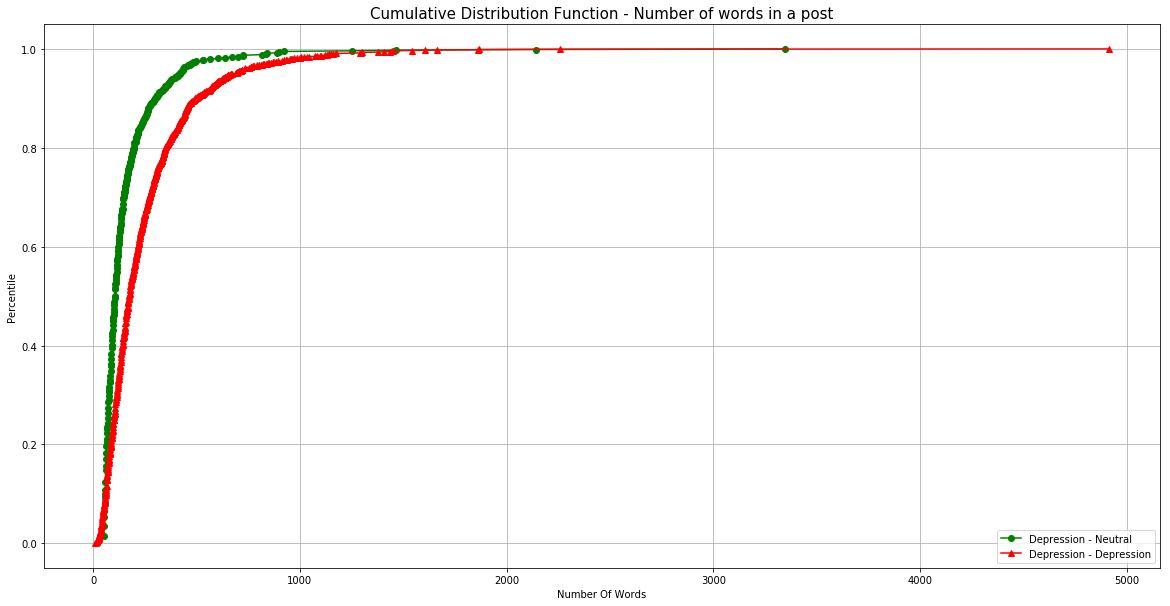

In [43]:
CDF_neutral, neutral_indice_list = generate_CDF(data=depression_group_users_neutral_posts)
CDF_depression, depression_indice_list = generate_CDF(data=depressed_group_depressed_posts)
#CDF_neutral_neutral, neutral_neutral_list = generate_CDF(data= non_depressed_people)

plt.figure(figsize=(20,10))
plt.plot(neutral_indice_list.values, CDF_neutral,color='green',marker='o', label='Depression - Neutral')
plt.plot(depression_indice_list.values, CDF_depression,color='red',marker='^', label='Depression - Depression')
#plt.plot(neutral_neutral_list.values, CDF_neutral_neutral,color='blue',marker='*', label='Neutral - Neutral')

plt.legend()
plt.title("Cumulative Distribution Function - Number of words in a post", size=15)
plt.ylabel("Percentile",size=10)
plt.xlabel("Number Of Words",size=10)
plt.grid()
plt.show()

In [44]:
# Lets drop the predicted column from our test groups
non_depressed_people = non_depressed_people.drop('predicted', axis=1)
depressed_group_depressed_posts = depressed_group_depressed_posts.drop('predicted', axis=1)

non_depressed_people['is_depressed'] = 0
depressed_group_depressed_posts['is_depressed'] = 1

In [45]:
# Combine both datasets
depressed_vs_neutral = pd.concat((non_depressed_people, depressed_group_depressed_posts), axis=0)
X = depressed_vs_neutral['post_text']
y = depressed_vs_neutral['is_depressed']

In [46]:
# Data transformation => Countvectorizer and Tfidf transformer
# removing english stopwords and analyzing on the word level
count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word')
X = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

In [47]:
# Adding the trigrams to our feature matrix
tri_grams_X = count_vect.fit_transform(depressed_vs_neutral['trigrams'].values)
tri_grams_X = tfidf_transformer.fit_transform(tri_grams_X)
#X = hstack((X, tri_grams_X,depressed_vs_neutral[liwc_cols]))

In [48]:
# Simple 80/20 ratio train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Applying a Linear Support Vector Classifier on our data
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 1,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

In [50]:
print("Accuracy Score:",score)
print("AUC Score:", np.mean(cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc')))

print("\n\t# === Confusion Matrix === #")
confusion_matrix_df = pd.DataFrame(data=confusion_matrix(y_pred=y_pred,y_true=y_test))
confusion_matrix_df.columns = ['predicted neutral', 'predicted depression']
confusion_matrix_df.index = ['actual neutral', 'actual depression']
confusion_matrix_df

Accuracy Score: 0.9274486094316807
AUC Score: 0.9770076772136373

	# === Confusion Matrix === #


,predicted neutral,predicted depression
actual neutral,438,34
actual depression,26,329


In [51]:
# Now lets try to classify and destinguish between the depression groups' neutral posts
# from the neutral group's posts
depression_group_users_neutral_posts = depression_group_users_neutral_posts.drop('predicted', axis=1)
depression_group_users_neutral_posts['is_depressed'] = 1

In [52]:
non_depressed_people = non_depressed_people.iloc[np.random.randint(non_depressed_people.shape[0], size=depression_group_users_neutral_posts.shape[0]), :]
print(depression_group_users_neutral_posts.shape)

(779, 105)


In [53]:
depressed_vs_neutral = pd.concat((non_depressed_people, depression_group_users_neutral_posts), axis=0)
depressed_vs_neutral = depressed_vs_neutral.reset_index().drop('index',axis=1)
X = depressed_vs_neutral['post_text'].map(post_to_wordlist)
X_copy = X.copy()
y = depressed_vs_neutral['is_depressed']

count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word', ngram_range=(1,1))
X = count_vect.fit_transform(X)
#tfidf_transformer = TfidfTransformer()
#X = tfidf_transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 100,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)

dummy_pred = svc.predict(X_test)
confusion_matrix(y_pred=dummy_pred, y_true= y_test)

# Problem is we rely on these words as most efficient to our classifier for future use
# this is not correct since the classifier doesn't produce good output (the confusion matrix above)
feature_names = count_vect.get_feature_names()
sorted_coef_index = svc.coef_[0].argsort()[:4000]
top_keywords = list(itemgetter(*sorted_coef_index)(feature_names))
print(top_keywords[:20])

cv = CountVectorizer(stop_words='english', lowercase=True,analyzer='word', ngram_range=(1,1))
cv_matrix = cv.fit_transform(X_copy)
tfidf_transformer = TfidfTransformer()
cv_matrix = cv_matrix.toarray()
vocab = cv.get_feature_names()
vocab_df = pd.DataFrame(cv_matrix, columns=vocab)
hot_keywords = vocab_df[top_keywords]
hot_keywords = hot_keywords.divide(depressed_vs_neutral['post_length'], axis=0)

In [76]:
stopWords = set(stopwords.words('english'))

num_words = 20000
corpus = depressed_vs_neutral['post_text'].copy()
corpus = corpus.str.replace('[', '')
corpus = corpus.str.replace(']','')
corpus = corpus.str.replace('.','')
corpus = corpus.str.replace('(','')
corpus = corpus.replace(')','')
corpus_copy = corpus.copy()
corpus = corpus.str.cat().split()
corpus = [word for word in corpus if word not in stopWords]

corpus_series = pd.Series(data=corpus, name='words')
top_keywords = corpus_series.value_counts().nlargest(num_words)#(len(corpus_series.value_counts()))
key_words = pd.DataFrame(data=np.zeros((X.shape[0], num_words)), columns=top_keywords.keys())
#key_words = pd.DataFrame(data=np.zeros((X.shape[0], len(corpus_series.value_counts()))), columns=top_keywords.keys())

In [77]:
for row in range(len(corpus_copy)):
    for word in corpus_copy[row]:
        if word in key_words.columns:
            key_words[word][row] += 1
        else:
            pass

In [78]:
# Apply our CV and Tfidf on the trigrams
# Eventually, creating a large matrix comprised of the fit user normal posts and the trigrams

tri_grams_X = count_vect.fit_transform(depressed_vs_neutral['trigrams'].values)
tri_grams_X = tfidf_transformer.fit_transform(tri_grams_X)
#X = hstack((X, tri_grams_X,depressed_vs_neutral[liwc_cols]))

In [79]:
# Adding the normalized features of post length and the number of distinct words per user

extra_features = normalize(depressed_vs_neutral[['post_length','num_distinct_words']], axis=1)
extra_features = pd.DataFrame(data=extra_features, columns=['post_length', 'num_distinct_words'])
#X = hstack((X, extra_features))

In [82]:
X = depressed_vs_neutral[liwc_cols]
print(X.shape)
X = X.reset_index().drop('index', axis=1)
X = pd.concat((X,key_words), axis=1)
X_columns = X.columns
norm = Normalizer()
X = norm.fit_transform(X)
X.shape

(1558, 85)


(1558, 20085)

In [83]:
pca = PCA(.95)
X = pca.fit_transform(X)
X.shape

(1558, 19)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 10,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

In [86]:
print("Accuracy Score:",score)
print("AUC Score:", np.mean(cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc')))

print("\n\t# === Confusion Matrix === #")
confusion_matrix_df = pd.DataFrame(data=confusion_matrix(y_pred=y_pred,y_true=y_test))
confusion_matrix_df.columns = ['predicted neutral', 'predicted depression']
confusion_matrix_df.index = ['actual neutral', 'actual depression']
confusion_matrix_df

Accuracy Score: 0.5641025641025641
AUC Score: 0.5994766353571218

	# === Confusion Matrix === #


,predicted neutral,predicted depression
actual neutral,87,76
actual depression,60,89


In [87]:
X_train = pd.DataFrame(data=X_train, columns=np.arange(X_train.shape[1]))
coef = list(sorted(zip(X_train.columns,abs(svc.coef_[0])),key=lambda x: x[1]))
coef_table = pd.DataFrame(np.array(coef).reshape(-1,2),columns=['Attributes','Coefficient'])
print('Coefficient for every feature:\n')
#print(len(coef_table[coef_table['Coefficient'] == '0.0']))
print(coef_table)

Coefficient for every feature:

    Attributes  Coefficient
0          3.0     0.027495
1         17.0     0.029923
2          4.0     0.137685
3          9.0     0.211548
4         11.0     0.465274
5         10.0     0.519626
6         15.0     0.676708
7          8.0     0.676817
8          0.0     0.695283
9         13.0     0.712337
10        14.0     0.771494
11         5.0     0.789951
12         6.0     0.831427
13        12.0     0.832455
14        16.0     0.967495
15         1.0     1.206679
16         2.0     1.479498
17         7.0     1.786290
18        18.0     4.959502


In [88]:
for i in coef_table.Attributes:
    print("Variance for {} vector: {}".format(i,pca.explained_variance_ratio_[int(i)]))

Variance for 3.0 vector: 0.0794906612917308
Variance for 17.0 vector: 0.006880019258132637
Variance for 4.0 vector: 0.061344365385071264
Variance for 9.0 vector: 0.03830446386974952
Variance for 11.0 vector: 0.027450414729463354
Variance for 10.0 vector: 0.036413072931362325
Variance for 15.0 vector: 0.011439037096510823
Variance for 8.0 vector: 0.04016888593312512
Variance for 0.0 vector: 0.17719445375893186
Variance for 13.0 vector: 0.020864086036660488
Variance for 14.0 vector: 0.01395020537834686
Variance for 5.0 vector: 0.06098011154608878
Variance for 6.0 vector: 0.057261742051152274
Variance for 12.0 vector: 0.02483473464699665
Variance for 16.0 vector: 0.008525007030454066
Variance for 1.0 vector: 0.13178314914206973
Variance for 2.0 vector: 0.10517063288180441
Variance for 7.0 vector: 0.04758563920195194
Variance for 18.0 vector: 0.0061390841621877445


###### Print Smallest and Largest important feature words
feature_names = np.array(count_vect.get_feature_names())
sorted_coef_index = svc.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

In [89]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))
        
no_features = 1000

tfidf_vectorizer = TfidfVectorizer(max_df=.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(depression_group_users_neutral_posts['post_text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

tf_vectorizer = CountVectorizer(max_df=.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(depression_group_users_neutral_posts['post_text'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [90]:
no_topics = 10

nmf = NMF(n_components=no_topics, random_state = 42, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50, random_state=42)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=10, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [91]:
no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
print("-------------------------------")
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
like just dont know want really people time feel think
Topic 1:
https com www youtube watch http imgur today music comments
Topic 2:
remember movie film think scene watched kid girl character ago
Topic 3:
games game playing played play video suggestions gaming really started
Topic 4:
im ive looking trying store answer recently starting school best
Topic 5:
song music lyrics like heard rock video sounds youtu help
Topic 6:
week champ ember unarmed sig won match today kids hatori
Topic 7:
que em não um da uma para tem eu com
Topic 8:
magic crystal elemental crystals nature blood energy magical does glass
Topic 9:
book books read reading favorite cover looking love recently series
-------------------------------
Topic 0:
duh remme standing electrons waves 2018 account users laptop shipped
Topic 1:
magic que em energy crystal spell não um unarmed does
Topic 2:
favorite book books read rolling vinyl history love recently collection
Topic 3:
com https www youtube watch http comments

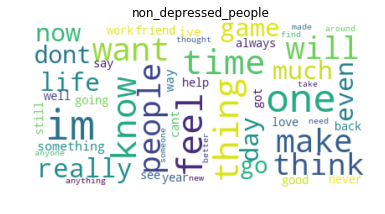

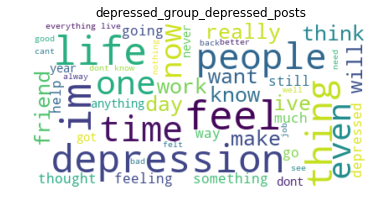

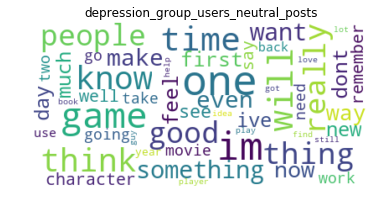

In [92]:
# Generate Word Clouds for each group
texts = [non_depressed_people, depressed_group_depressed_posts, depression_group_users_neutral_posts]
titles = ['non_depressed_people', 'depressed_group_depressed_posts', 'depression_group_users_neutral_posts']
for i,x in zip(texts,titles):
    generate_wordcloud(text=i,title=x)

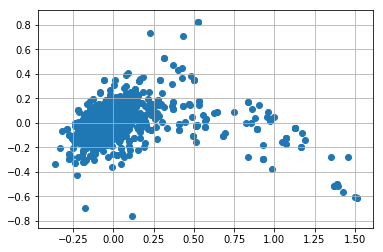

In [93]:
liwc_temp_df = depressed_vs_neutral[liwc_cols].copy()
pca = PCA(n_components=2)

liwc_temp_df = pca.fit_transform(liwc_temp_df)
liwc_temp_df.shape
plt.scatter(data=liwc_temp_df, x=liwc_temp_df[:,0], y=liwc_temp_df[:, 1])
plt.grid()
plt.show()

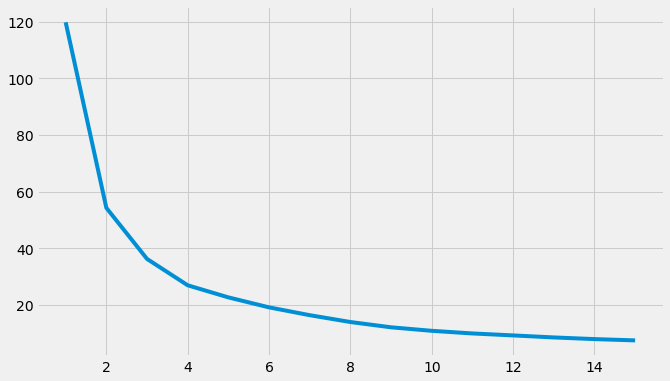

In [94]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(liwc_temp_df)
    wcss.append(kmeans.inertia_)

with plt.style.context(('fivethirtyeight')):
    plt.figure(figsize=(10,6))
    plt.plot(range(1, 16), wcss)
    plt.show()


In [95]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(liwc_temp_df)


1    779
0    779
Name: is_depressed, dtype: int64


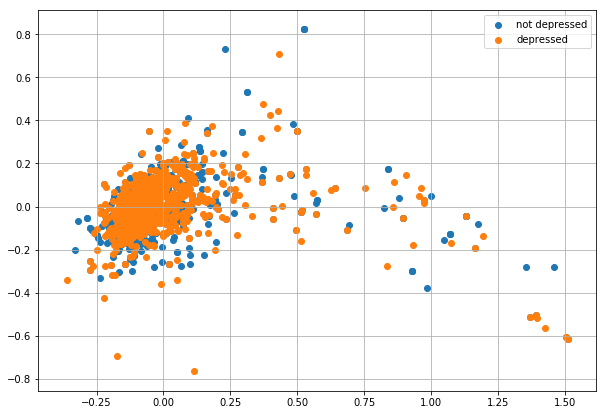

In [96]:
liwc_temp_df = np.column_stack((liwc_temp_df, depressed_vs_neutral['is_depressed'].values))
print(depressed_vs_neutral['is_depressed'].value_counts())
plt.figure(figsize=(10,7))
plt.scatter(data=liwc_temp_df, x=liwc_temp_df[:,0][liwc_temp_df[:,2] == 0], y=liwc_temp_df[:,1][liwc_temp_df[:,2] == 0], label='not depressed')
plt.scatter(data=liwc_temp_df, x=liwc_temp_df[:,0][liwc_temp_df[:,2] == 1], y=liwc_temp_df[:,1][liwc_temp_df[:,2] == 1], label='depressed')
plt.grid()
plt.legend()
plt.show()

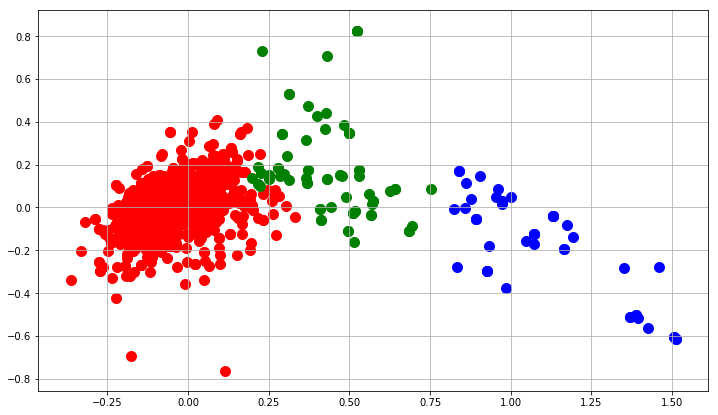

In [97]:
plt.figure(figsize=(12,7))
plt.scatter(liwc_temp_df[y_hc == 0, 0],liwc_temp_df[y_hc == 0, 1] , s = 100, c = 'red')
plt.scatter(liwc_temp_df[y_hc == 1, 0],liwc_temp_df[y_hc == 1, 1] , s = 100, c = 'blue')
plt.scatter(liwc_temp_df[y_hc == 2, 0],liwc_temp_df[y_hc == 2, 1] , s = 100, c = 'green')
plt.grid(True)
plt.show()

In [98]:
#X = depressed_vs_neutral['post_text']
#y = depressed_vs_neutral['is_depressed']
#X = liwc_temp_df
#count_vect = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(2,2), lowercase=True, binary=True)
#X  = count_vect.fit_transform(X)

In [99]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
vocab_size = 1000
corpus = depressed_vs_neutral['post_text'].copy()
encoded_corpus = [one_hot(d, vocab_size) for d in corpus]

# pad corpus
max_length = 1000
padded_docs = pad_sequences(encoded_corpus, maxlen=max_length, padding='post')

Using TensorFlow backend.


In [100]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, y, test_size = 0.2, random_state = 42)
print(X_train.shape[0])

1246


In [101]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, regularizers, Embedding, Flatten

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length))
model.add(Flatten())

model.add(Dense(1000, bias_regularizer=regularizers.l2(.5)))
model.add(Activation('relu'))

model.add(Dense(500, bias_regularizer=regularizers.l2(.5)))
model.add(Activation('relu'))

model.add(Dense(500, bias_regularizer=regularizers.l2(.5)))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [102]:
# Using binary crossentropy loss function because we have a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.metrics_names)

['loss', 'acc']


In [103]:
batch_size = 1024
n_epohcs = 30

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epohcs, verbose=True, validation_split=0.1)
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=True)

Train on 1121 samples, validate on 125 samples
Epoch 1/30
1121/1121 [==============================] - 2s 2ms/step - loss: 0.7020 - acc: 0.5112 - val_loss: 0.7064 - val_acc: 0.5040
Epoch 2/30
1121/1121 [==============================] - 1s 955us/step - loss: 0.7033 - acc: 0.5058 - val_loss: 0.7068 - val_acc: 0.5040
Epoch 3/30
1121/1121 [==============================] - 1s 1ms/step - loss: 0.7052 - acc: 0.5040 - val_loss: 0.6944 - val_acc: 0.5040
Epoch 4/30
1121/1121 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5129 - val_loss: 0.7068 - val_acc: 0.5040
Epoch 5/30
1121/1121 [==============================] - 1s 1ms/step - loss: 0.7001 - acc: 0.5156 - val_loss: 0.7190 - val_acc: 0.5040
Epoch 6/30
1121/1121 [==============================] - 1s 977us/step - loss: 0.7129 - acc: 0.5058 - val_loss: 0.6996 - val_acc: 0.5040
Epoch 7/30
1121/1121 [==============================] - 1s 961us/step - loss: 0.6928 - acc: 0.5094 - val_loss: 0.6969 - val_acc: 0.5040
Epoch 8/3

In [104]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy:", scores[1]) 

312/312 [==============================] - 0s 546us/step
Accuracy: 0.44871794871794873


In [105]:
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]
print(confusion_matrix(y_pred=y_pred,y_true=y_test))
model.summary()

[[72 91]
 [81 68]]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 10)          10000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              10001000  
_________________________________________________________________
activation_1 (Activation)    (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               25

###### Future code block for creating a new liwc dataframe
temp_df = full_df[full_df['post_length'] > 0][['post_text','submission_id']].copy()
for i in liwc_cols:
    temp_df[i] = i
temp_df = temp_df.reset_index().drop('index',axis=1)
temp_df.head()

##### Run this block if you want to create an LIWC dataframe
liwc_obj = liwc_analysis(temp_df['post_text'][0])

temp = pd.DataFrame(data=liwc_obj, index=[0])
blu = pd.Series(data=temp_df['submission_id'][0],name='submission_id')
temp = pd.concat((temp,blu),axis=1)
for i in range(1, len(temp_df)):
    print(i)
    text = liwc_analysis(temp_df['post_text'][i])
    temp_obj = pd.DataFrame(data=text, index=[0])
    temp_series = pd.Series(data=full_df['submission_id'][i], name='submission_id')
    temp_obj = pd.concat((temp_obj, temp_series), axis=1)
    temp = pd.concat((temp, temp_obj), axis=0)


temp.to_csv('temp2.csv')


In [106]:
from gensim.models import word2vec
import multiprocessing
num_features = 100   # Dimensionality of the hidden layer representation
min_word_count = 40   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count()      # Number of threads to run in parallel set to total number of cpus.
context = 5          # Context window size (on each side)                                                       
downsampling = 1e-3

print("Training model...")
model = word2vec.Word2Vec(depressed_vs_neutral.post_text, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling);

Training model...


In [107]:
Z = model.wv.syn0

print(Z[0].shape)
Z.shape

(100,)


(68, 100)

In [112]:
df.columns

Index(['_submission_id', '_title', '_score', '_num_comments', '_title_length',
       '_subreddit', '_post_text', '_comment_karma', '_link_karma',
       '_upvote_ratio', '_date_created', '_user_name', '_num_words_title',
       '_post_length', '_num_words_post'],
      dtype='object')

In [ ]:
tdelta = datetime.strptime(s2, FMT)

from datetime import datetime
s1 = '10:33:26'
s2 = '11:15:49' # for example
FMT = '%Y-%m-%d %H:%M:%S'

In [131]:
from datetime import datetime as dt
FMT = '%Y-%m-%d %H:%M:%S'
S = '2018-12-07 12:23:09'
F = '2018-12-07 15:03:56'
tdelta = dt.strptime(S,FMT) - dt.strptime(F,FMT)

In [156]:
df['time_delta'] = df['_date_created'].apply(lambda x: dt.strptime(x, FMT))

In [ ]:
df

In [163]:
temp_temp = df[df['_user_name'] == 'alpacaballs']['time_delta'].sort_values(ascending=False)

In [164]:
temp_temp.shape

(478,)

In [165]:
tdelta_array = np.zeros((temp_temp.shape[0],))

In [168]:
for i in temp_temp:
    print(i)

2018-12-06 18:32:11
2018-12-06 18:32:11
2018-12-06 18:32:11
2018-12-06 18:32:11
2018-12-06 17:31:29
2018-12-06 17:31:29
2018-12-06 17:31:29
2018-12-06 17:31:29
2018-12-06 17:31:29
2018-12-06 17:18:40
2018-12-06 17:18:40
2018-12-06 17:18:40
2018-12-06 17:18:40
2018-12-06 17:18:40
2018-12-06 16:58:26
2018-12-06 16:58:26
2018-12-06 16:58:26
2018-12-06 16:58:26
2018-12-06 16:58:26
2018-12-06 16:47:59
2018-12-06 16:47:59
2018-12-06 16:47:59
2018-12-06 16:47:59
2018-12-06 16:47:59
2018-12-06 16:37:49
2018-12-06 16:37:49
2018-12-06 16:37:49
2018-12-06 16:37:49
2018-12-06 16:37:49
2018-12-06 16:36:26
2018-12-06 16:36:26
2018-12-06 16:36:26
2018-12-06 16:36:26
2018-12-06 16:36:26
2018-12-06 16:34:11
2018-12-06 16:34:11
2018-12-06 16:34:11
2018-12-06 16:34:11
2018-12-06 16:34:11
2018-12-06 14:38:00
2018-12-06 14:38:00
2018-12-06 14:38:00
2018-12-06 14:38:00
2018-12-06 14:38:00
2018-12-05 22:13:05
2018-12-05 22:13:05
2018-12-05 22:13:05
2018-12-05 22:13:05
2018-12-05 22:13:05
2018-12-05 21:55:19


In [179]:
temp_temp = df[['_user_name','_date_created','_submission_id','time_delta']].sort_values(by='_user_name')

In [ ]:
for name in temp_temp['_user_name']:
    temp_time_df = df[df['_user_name'] == name]
    temp_time_df = temp_time_df.sort_values(by='_date_created', ascending=False)
    if len(temp_time_df) == 1:
        df['time_delta'][temp_time_df.index] = 0
    else:
        pass

In [196]:
temp_time_df = df[df['_user_name'] == name]
temp_time_df.shape

(1, 16)